# Analysis of A/B Experiment in Food Delivery Service

## **Objective**:  
Analyze the impact of a new feature in the mobile application: a block on the homepage displaying the user's order history.  
This block allows users to repeat orders or add items to their cart directly from the block.  

### **Experiment Groups**:  
- **Group "a" (control)**: Does not see the order history block.  
- **Group "b" (test)**: Sees the new order history block.  

---

## **Available Data**:  

### **1. `data_ab_groups.csv`**:  
Details of users and their assigned experimental group.  
Columns:  
- **user_id**: User identifier.  
- **ab_group**: Experimental group ("a" or "b").  

### **2. `data_financial.csv`**:  
Information about user spending.  
Columns:  
- **date**: Date of app usage.  
- **user_id**: User identifier.  
- **spendings**: User spending in rubles.  

---

## **Tasks**:  

### **1. Identify Users in Multiple Experiment Groups**:  
Find the number of users who were assigned to more than one experimental group.  

### **2. Create a Summary Table**:  
Generate a table with the following columns:  
- **user_id**: User identifier.  
- **ab_group**: Experimental group.  
- **spendings**: Total spendings of the user aggregated over the entire period.  

#### **Notes**:  
- Exclude users assigned to multiple groups from the final table.  
- Aggregate user spendings over the entire experiment period.  

### **3. Visualize Spending Distribution**:  
Create a boxplot showing the distribution of user spendings for each experimental group.  

#### **Analysis**:  
- Comment on the presence of outliers.  
- Handle outliers appropriately if they exist.  

### **4. Statistical Analysis and Experiment Conclusion**:  
- Select a statistical test to evaluate the experiment results.  
- Calculate the **uplift** in user spendings between the groups.  
- Determine the **statistical significance** of the uplift.  
- Provide recommendations to the manager based on the findings.  

---

## **Output**:  
Deliver a clear and concise analysis with insights on whether the new feature improves user spending and suggestions for next steps.


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

%matplotlib inline

In [11]:
# Загрузка данных о группах
data_ab_groups = pd.read_csv(r'/kaggle/input/data-ab-groups/data_ab_groups.csv', sep=";")
data_financial = pd.read_csv(r'/kaggle/input/data-ab-groups/data_financial.csv', sep=";")

### Task 1 - Определение пользователей, которые участвуют в более чем одной группе

In [12]:
# Task 1 - Определение пользователей, которые участвуют в более чем одной группе
users_in_multiple_groups  = data_ab_groups.pivot_table(data_ab_groups, index="user_id", aggfunc={"ab_group":"nunique"}).query("ab_group > 1").index

### Task 2 - сформировать таблицу с колонками: айди пользователя, группа эксперимента, траты пользователя.

In [13]:
# Task 2 - сформировать таблицу с колонками: айди пользователя, группа эксперимента, траты пользователя.
groups_financial = pd.merge(data_financial, data_ab_groups, on="user_id", how="left")

### Task 3 - Построить boxplot по тратам пользователей в разрезе группы эксперимента.

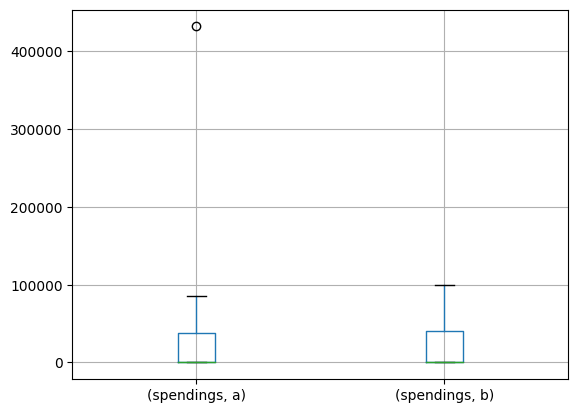

In [14]:
# Все юзеры с одной группой A или B
users_in_one_group = groups_financial.pivot_table(index="user_id", columns="ab_group", aggfunc={"spendings":"sum"}).query("user_id not in @users_in_multiple_groups").boxplot(showfliers=True)

In [15]:
users_in_one_group_date = groups_financial.pivot_table(index="user_id", columns="ab_group", aggfunc={"spendings":"sum"}).query("user_id not in @users_in_multiple_groups")

In [16]:
users_in_one_group_date.describe()

spendings              
ab_group              a             b
count       2081.000000   2100.000000
mean       17636.504085  20197.667143
std        23846.105988  22860.440791
min            0.000000      0.000000
25%            0.000000      0.000000
50%            0.000000      0.000000
75%        37380.000000  40649.250000
max       431883.000000  99252.000000

### Task 4 - Выбрать статистический критерий, подвести итоги по эксперименту 

# Контрольная группа A


In [17]:
# Контрольная группа A
Q1_control = users_in_one_group_date['spendings'].quantile(0.25)
Q3_control = users_in_one_group_date['spendings'].quantile(0.75)

IQR_control = Q3_control - Q1_control

lower_bound_control = Q1_control - 1.5 * IQR_control
upper_bound_control = Q3_control + 1.5 * IQR_control

print(f'Lower bound: {lower_bound_control}')
print(f'Upper bound: {upper_bound_control}')

Lower bound: ab_group
a   -56070.000
b   -60973.875
dtype: float64
Upper bound: ab_group
a     93450.000
b    101623.125
dtype: float64


In [18]:
cleaned_data = users_in_one_group_date[ (users_in_one_group_date['spendings'] >= lower_bound_control) & (users_in_one_group_date['spendings'] <  upper_bound_control)]

In [19]:
cleaned_data.describe()

spendings              
ab_group             a             b
count      2080.000000   2100.000000
mean      17437.347115  20197.667143
std       22052.910093  22860.440791
min           0.000000      0.000000
25%           0.000000      0.000000
50%           0.000000      0.000000
75%       37377.750000  40649.250000
max       85280.000000  99252.000000

array([[<Axes: title={'center': "('spendings', 'a')"}>,
        <Axes: title={'center': "('spendings', 'b')"}>]], dtype=object)

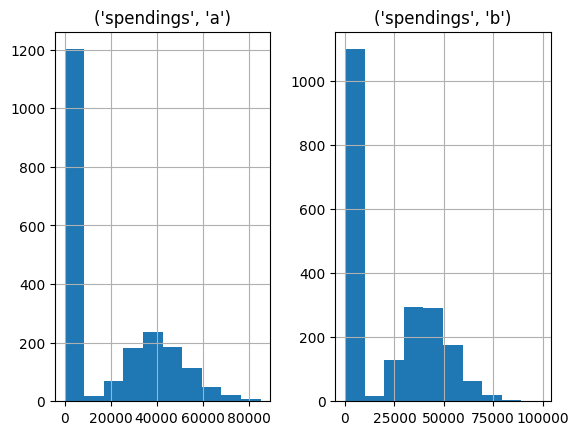

In [20]:
cleaned_data.hist()

In [21]:
# Преобразование MultiIndex столбцов в обычные столбцы
cleaned_data.columns = cleaned_data.columns.get_level_values('ab_group')
cleaned_data

ab_group,a,b
user_id,,
5214352,54648.0,NaN
6980064,47990.0,NaN
7195752,62001.0,NaN
7367490,NaN,24010.0
7770180,17155.0,NaN
...,...,...
5002781779,NaN,0.0
5002933928,NaN,0.0
5002989237,NaN,0.0


In [22]:
# Проверка наличия пропущенных значений
print("Пропущенные значения в группе 'a':")
print(cleaned_data['a'].isna().sum())

print("\nПропущенные значения в группе 'b':")
print(cleaned_data['b'].isna().sum())

# Убедитесь, что в обеих группах есть данные
print("\nКоличество данных в группе 'a':")
print(cleaned_data['a'].dropna().count())

print("\nКоличество данных в группе 'b':")
print(cleaned_data['b'].dropna().count())

Пропущенные значения в группе 'a':
2101

Пропущенные значения в группе 'b':
2081

Количество данных в группе 'a':
2080

Количество данных в группе 'b':
2100


In [23]:
mean_values = cleaned_data.mean()

In [24]:
# Расчет аплифта
mean_a = mean_values['a']
mean_b = mean_values['b']

print(f'Mean group A: {mean_a}\nMean group B: {mean_b}')

Mean group A: 17437.347115384615
Mean group B: 20197.667142857143


In [25]:
uplift = (mean_a - mean_b) / mean_b * 100
uplift

-13.666528950838309

In [26]:
data_a = cleaned_data['a'].dropna()
data_b = cleaned_data['b'].dropna()

In [27]:
# Статистическая значимость
t_stat, p_value = stats.ttest_ind(data_a, data_b, equal_var=False)

print(f'T-test statistic: {t_stat}')
print(f'P-value: {p_value}')

T-test statistic: -3.9731440798208886
P-value: 7.212687292694273e-05


In [28]:
# Вывод результатов эксперимента
print("Краткий вывод:")
print("- Uplift: -13.67. Группа A тратит меньше, чем группа B, и разница значительная.")
print("- T-test statistic: -3.97. Отрицательное значение указывает, что средние траты в группе A ниже, чем в группе B.")
print("- P-value: 0.000072. Разница в тратах статистически значима, нулевая гипотеза отвергается.")


Краткий вывод:
- Uplift: -13.67. Группа A тратит меньше, чем группа B, и разница значительная.
- T-test statistic: -3.97. Отрицательное значение указывает, что средние траты в группе A ниже, чем в группе B.
- P-value: 0.000072. Разница в тратах статистически значима, нулевая гипотеза отвергается.
